# Geometric Tensor Learning
---

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

import networkx as nx

from util.t2m import t2m
from util.m2t import m2t
from util.update_L_nograd import update_L
from util.update_X_nograd import update_X
from util.update_Sigma import update_Sigma
from util.update_Lambda_nograd import update_Lambda
from util.update_L_nograd import fn_val as fnval_L
from util.update_X_nograd import fn_val as fnval_X

In [2]:
def fn_val_G(G, L, Lambda, alpha, gamma):
    n = len(G)
    val_smooth = [gamma[i]*np.trace(t2m(G[i],i).transpose() @ Phi[i] @ t2m(G[i],i)) for i in range(i)]
    val_Lag = [alpha[i]*np.linalg.norm(L-G[i]-Lambda[i])**2 for i in range(n)]
    fn_val = sum(val_smooth) + sum(val_Lag)
    return fn_val, val_smooth, val_Lag

def fn_val_L(L, Y, Lx, G, Lambda, alpha):
    n = len(L.shape)
    val_Y = np.linalg.norm(Y[~Y.mask]-L[~Y.mask])**2
    val_Lag1 = [alpha[0][i]*np.linalg.norm(L-G[i]-Lambda[0][i])**2 for i in range(n)]
    val_Lag2 = [alpha[1][i]*np.linalg.norm(L-Lx[i]-Lambda[1][i])**2 for i in range(n)]
    fn_val = val_Y + sum(val_Lag1) + sum(val_Lag2)
    return fn_val, val_Y, val_Lag1, val_Lag2

In [3]:
sizes = (10, 15, 12, 16)
n = len(sizes)

In [4]:
X = np.random.standard_normal(size=sizes) # WGN to generate a stationary signal.

In [5]:
G = [nx.erdos_renyi_graph(sizes[i],0.3) for i in range(n)] # List of graphs for each mode
Phi = [nx.laplacian_matrix(G[i]).todense() for i in range(n)]


In [6]:
# Generate data smooth in Cartesian graph G.
ranks = (5, 5, 5, 5)
W_all = 1
V_all = 1

for i in range(n):
    W, V = np.linalg.eigh(nx.laplacian_matrix(G[i]).todense())
    temp_eig = np.flip(np.sort(abs(np.random.randn(ranks[i]))))
    W_all = np.kron(np.ones(ranks[i]), W_all) + np.kron(temp_eig,np.ones(ranks[:i]).flatten('F'))
    V_all = np.kron(V_all, V[:,:ranks[i]])

X_smooth = np.tensordot(V_all, W_all, axes=([1],[0])).reshape(sizes)
del W_all, V_all

In [7]:
noise_ratio = 0.01
missing_ratio = 0
norm_X = np.sqrt(np.sum(X_smooth**2))
mask = np.random.uniform(size=np.prod(sizes)).reshape(sizes)-missing_ratio<0
Y = ma.array(X_smooth + noise_ratio * np.sqrt(norm_X) * np.random.standard_normal(sizes), mask = mask)

In [17]:
def initialize_nograd(n):
    # Parameters
    alpha = [[.01 for i in range(n)], 
        [.01 for i in range(n)], 
        [.01 for i in range(n)], 
        [.01 for i in range(n)]]
    theta = [10**-4 for i in range(n)]
    gamma = [.01 for i in range(n)]

    # Initializations
    L = np.zeros(sizes)
    G_var = [np.zeros(sizes) for i in range(n)]
    X = [np.zeros(sizes) for i in range(n)]
    Lx = [np.zeros(sizes) for i in range(n)]
    Sigma = []
    for i in range(n):
        temp = np.random.standard_normal(sizes[i]**2).reshape([sizes[i], sizes[i]])
        Sigma.append(temp@temp.transpose())

    Lambda = [[np.zeros(sizes) for i in range(n)],
        [np.zeros(sizes) for i in range(n)],
        [np.zeros(sizes) for i in range(n)],
        [np.zeros([sizes[i],sizes[i]]) for i in range(n)]]
    
    return L, G_var, Lx, X, Sigma, Lambda, alpha, theta, gamma

L, G_var, Lx, X, Sigma, Lambda, alpha, theta, gamma = initialize_nograd(n)

In [18]:
G_inv = [np.linalg.inv(gamma[i]*Phi[i] + alpha[0][i]*np.eye(sizes[i])) for i in range(n)]
iter = 0
fval_tot = []
# ADMM Loop
while True:
    # L Update
    temp = np.zeros(sizes)
    for i in range(n):
        temp += alpha[1][i]*(G_var[i] + Lambda[0][i])
        temp += alpha[2][i]*(Lx[i] + Lambda[1][i])
    
    print("Function value for variable L: {}".format(fn_val_L(L, Y, Lx, G_var, Lambda[:2], alpha[:2])[0]))
    L = temp/(sum(alpha[0]) + sum(alpha[1]) + 1)
    L[~Y.mask] = L[~Y.mask] + Y[~Y.mask]/(sum(alpha[0]) + sum(alpha[1]) + 1)
    fval_data = fn_val_L(L, Y, Lx, G_var, Lambda[:2], alpha[:2])
    print("Function value for variable L after update: {}".format(fval_data[0]))
    
    # G Update
    print("Function value for variable G: {}".format(fn_val_G(G_var, L, Lambda[0], alpha[0], gamma)[0]))
    G_var = [m2t(alpha[0][i]*G_inv[i]*t2m(L-Lambda[0][i], i), sizes, i) for i in range(n)]
    fval_G = fn_val_G(G_var, L, Lambda[0], alpha[0], gamma)
    print("Function value for variable G after update: {}".format(fval_G[0]))

    # Lx Update
    print("Function value for variable Lx before update: {}".format(fnval_L(Lx, L, X, Lambda[1:], Sigma, alpha[1:])[0]))
    Lx, fval_L, fval_low, _, _ = update_L(Lx, L, X, Lambda[1:], Sigma, alpha[1:], track_fval=True)
    print("Function value for variable Lx after update: {}".format(fval_L))

    # X Update
    print("Function value for variable X before update: {}".format(sum(fnval_X(X,Lx,Lambda[2:],Sigma,alpha[2:])[1])))
    X, _, fval_X, _ = update_X(X, Lx, Lambda[2:], Sigma, alpha[2:], track_fval=True)
    print("Function value for variable X after update: {}".format(sum(fval_X)))

    # Sigma Update 
    Sigma, fval_Sigma, _, _ = update_Sigma(Sigma, Lx, X, Phi, Lambda[3], alpha[3], theta, track_fval=True)
    
    fval_tot.append(fval_data[1] + fval_G[0] + sum(fval_low) + sum(fval_X) + fval_Sigma)
    print('Total Objective Function Value at iter {}: {}'.format(iter, fval_tot[-1]))
    # Dual Update
    Lambda = update_Lambda(Lambda,L,Lx,X,G_var,Sigma)[0]
    iter += 1
    if iter%10==9:
        break

Function value for variable L: 15125.06432595132
Function value for variable L after update: 1120.3751352556533
Function value for variable G: 518.6921922479876
Function value for variable G after update: 184.4311612628396
Function value for variable Lx before update: 734.1272849778918
Function value for variable Lx after update: 474.7811888538981
Function value for variable X before update: 129.6730480619969
Function value for variable X after update: 29.145396264619162
Total Objective Function Value at iter 0: 955.1542133738562
Function value for variable L: 2641.8601426888126
Function value for variable L after update: 2628.7197764983757
Function value for variable G: 515.0685101618277
Function value for variable G after update: 447.8901681006661
Function value for variable Lx before update: 2487.8356879470757
Function value for variable Lx after update: 576641272230123.5
Function value for variable X before update: 0.0
Function value for variable X after update: 0.0
Total Objective

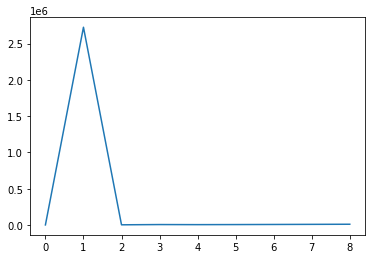

In [10]:
plt.plot(fval_tot)

In [11]:

temp = np.zeros(sizes)
for i in range(n):
    temp += alpha[1][i]*(Lambda[0][i])
    temp += alpha[2][i]*(Lambda[1][i])

In [12]:
np.linalg.norm(Y-L)

38.81003440168442